In [1]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
from utils import iter_df_read, get_array_diff
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")

# Modificar por ruta local de almacenamiento de datos
BASE = "/media/giani/Gianicosas/Magister/Proyecto/"

# Operacionalización de datos

### Alumno desertor
- Requisito: No se debe haber titulado para la carrera analizada

### Tipos de deserción

- Sale del sistema y no vuelve a ingresar
- Sale del sistema y vuelve después de 1, 2 ó 3 años a la misma carrera en la misma institución (no deserta, "congela")
- Sale y vuelve a otra carrera en la misma institución (seudo deserción?)
- Sale y vuelve a la misma carrera en otra institución (seudo deserción?)
- Sale y vuelve a otra carrera en otra institución (seudo deserción?)
- Sale del sistema, vuelve a ingresar, pero no termina ni se matricula 2022 (múltiple deserción?)

# Matriculados

## Lectura de datos matriculados

Fuente: https://datosabiertos.mineduc.cl/matricula-en-educacion-superior/

- Se considera todos los matriculados en CFT / IP desde 2015

In [2]:
# Matriculados de CFT / IP
mat_cft_ip = pd.read_csv(f"{BASE}/tmp_data/fechas_titulacion.csv")
mat_cft_ip.head()

,codigo_unico,mrun,fecha_obtencion_titulo
0,I143S26C9J2V2,26379527.0,20220228.0
1,I260S22C108J1V1,4120917.0,20220228.0
2,I116S34C17J2V1,4348827.0,20220228.0
3,I260S21C263J2V1,20301532.0,20220228.0
4,I143S2C651J2V1,3498846.0,20220228.0


In [3]:
mat_cft_ip.isna().sum()

codigo_unico                    0
mrun                            0
fecha_obtencion_titulo    1194617
dtype: int64

In [4]:
# Se carga datos de matrícula para estos alumnos, considerando todas las instituciones
cols = [
    'cat_periodo', 'codigo_unico', 'mrun', 'tipo_inst_1', 'dur_estudio_carr',
    'cod_inst', 'cod_carrera'
]

mruns = mat_cft_ip["mrun"].unique()

matriculados = pd.concat([
    iter_df_read(f, "mrun", mruns, sep=";", usecols=cols)
    for f in tqdm(
        glob(f"{BASE}/raw_data/post_2015/20220719_Matrícula_Ed_Superior_*.csv"),
        total=8
    )
]).drop_duplicates().reset_index(drop=True)

  0%|          | 0/8 [00:00<?, ?it/s]

In [5]:
# Se agrega columna que indica titulación

if "fecha_obtencion_titulo" not in matriculados.columns:
    len_or = matriculados.shape[0]
    matriculados = pd.merge(
        matriculados,
        mat_cft_ip,
        how="left"
    )
    
    assert matriculados.shape[0] == len_or

## Pre procesamiento: Año de titulación 

### Por carrera

In [6]:
matriculados["anio_titulacion"] = matriculados["fecha_obtencion_titulo"].fillna("").astype(str).str[:4].replace([""], [np.nan]).astype(float)
matriculados["anio_titulacion"].describe().round()

count    1073280.0
mean        2019.0
std            1.0
min         2015.0
25%         2018.0
50%         2020.0
75%         2021.0
max         2022.0
Name: anio_titulacion, dtype: float64

### Cualquier carrera

In [7]:
tit_cualquier_carrera = matriculados[
    matriculados["anio_titulacion"].notna()
]["mrun"].unique()

matriculados["titulado_cualquier_carrera"] = np.where(matriculados["mrun"].isin(tit_cualquier_carrera), 1, 0)    

## Pre procesamiento: Último año de matrícula 

### Por carrera

In [8]:
if "ultimo_anio_matricula" not in matriculados.columns:
    len_or = matriculados.shape[0]
    matriculados = pd.merge(
        matriculados,
        matriculados.groupby(["mrun", "codigo_unico"]).agg({
            "cat_periodo": "max"
        }).reset_index().rename(columns={
            "cat_periodo": "ultimo_anio_matricula"
        }),
        how="left"
    ).drop_duplicates().reset_index(drop=True)
    
    assert matriculados.shape[0] == len_or

In [9]:
matriculados["ultimo_anio_matricula"].describe().round()

count    3743349.0
mean        2020.0
std            2.0
min         2015.0
25%         2018.0
50%         2020.0
75%         2022.0
max         2022.0
Name: ultimo_anio_matricula, dtype: float64

### Cualquier carrera

In [10]:
if "ult_anio_mat_cualquier_carrera" not in matriculados.columns:
    len_or = matriculados.shape[0]
    matriculados = pd.merge(
        matriculados,
        matriculados.groupby(["mrun"]).agg({
            "cat_periodo": "max"
        }).reset_index().rename(columns={
            "cat_periodo": "ult_anio_mat_cualquier_carrera"
        }),
        how="left"
    ).drop_duplicates().reset_index(drop=True)
    
    assert matriculados.shape[0] == len_or

## Pre procesamiento: Deserciones

In [11]:
cft_ip = ["Institutos Profesionales", "Centros de Formación Técnica"]

In [42]:
anios = []

for a in range(2015, 2022):
    m_a = matriculados[
        (matriculados["cat_periodo"]==a)
        & (matriculados["tipo_inst_1"].isin(cft_ip))
    ].copy()
    
    m_a["tmp_"] = m_a["mrun"].astype(str) + m_a["codigo_unico"]
    m_a["tmp_2"] = m_a["mrun"].astype(str) + m_a["cod_inst"].astype(str)
    m_a["tmp_3"] = m_a["mrun"].astype(str) + m_a["cod_carrera"].astype(str)
    
    # Criterio 1: Sale del sistema y no vuelve a ingresar
    m_a["desertor_1"] = np.where(
        (m_a["anio_titulacion"].isna()) & (m_a['ult_anio_mat_cualquier_carrera'] == a), 1, 0
    )
    
    # Criterio 2.1: Sale del sistema y vuelve después de 1 año a la misma carrera en la misma institución
    m_a_next_1 =  matriculados[
        (matriculados["cat_periodo"]== a + 1)
    ].copy()[["mrun", "codigo_unico", "cod_inst", "cod_carrera"]].drop_duplicates()

    m_a_next_1["tmp_"] = m_a_next_1["mrun"].astype(str) + m_a_next_1["codigo_unico"]

    m_a_next_2 =  matriculados[
        (matriculados["cat_periodo"]== a + 2)
    ].copy()[["mrun", "codigo_unico"]].drop_duplicates()

    m_a_next_2["tmp_"] = m_a_next_2["mrun"].astype(str) + m_a_next_2["codigo_unico"]

    m_a["desertor_2_1"] = np.where(
        (~m_a["tmp_"].isin(m_a_next_1["tmp_"])) & (m_a["tmp_"].isin(m_a_next_2["tmp_"])),
        1,
        0
    )
    
    # Criterio 2.2: Sale del sistema y vuelve después de 2 años a la misma carrera en la misma institución
    m_a_next_3 =  matriculados[
        (matriculados["cat_periodo"]== a + 3)
    ].copy()[["mrun", "codigo_unico"]].drop_duplicates()

    m_a_next_3["tmp_"] = m_a_next_3["mrun"].astype(str) + m_a_next_3["codigo_unico"]

    m_a["desertor_2_2"] = np.where(
        (~m_a["tmp_"].isin(m_a_next_1["tmp_"])) & (m_a["tmp_"].isin(m_a_next_3["tmp_"])),
        1,
        0
    )
    
    # Criterio 2.3: Sale del sistema y vuelve después de 3 años a la misma carrera en la misma institución
    m_a_next_4 =  matriculados[
        (matriculados["cat_periodo"]== a + 4)
    ].copy()[["mrun", "codigo_unico"]].drop_duplicates()

    m_a_next_4["tmp_"] = m_a_next_4["mrun"].astype(str) + m_a_next_4["codigo_unico"]

    m_a["desertor_2_3"] = np.where(
        (~m_a["tmp_"].isin(m_a_next_1["tmp_"])) & (m_a["tmp_"].isin(m_a_next_4["tmp_"])),
        1,
        0
    )
    
    # Criterio 3: Sale y vuelve a otra carrera en la misma institución al año siguiente
    m_a_next_1["tmp_2"] = m_a_next_1["mrun"].astype(str) + m_a_next_1["cod_inst"].astype(str)
    m_a_next_1["tmp_3"] = m_a_next_1["mrun"].astype(str) + m_a_next_1["cod_carrera"].astype(str)
    
    m_a["desertor_3"] = np.where(
        (m_a["tmp_2"].isin(m_a_next_1["tmp_2"])) & (~m_a["tmp_"].isin(m_a_next_1["tmp_"])),
        1,
        0
    )
    
    # Criterio 4: Sale y vuelve a la misma carrera en otra institución al año siguiente
    m_a["desertor_4"] = np.where(
        (m_a["tmp_3"].isin(m_a_next_1["tmp_3"])) & (~m_a["tmp_2"].isin(m_a_next_1["tmp_2"])),
        1,
        0
    )
    
    # Criterio 5: Sale y vuelve a otra carrera en otra institución al año siguiente
    m_a["desertor_5"] = np.where(
        (~m_a["tmp_3"].isin(m_a_next_1["tmp_3"])) & (~m_a["tmp_2"].isin(m_a_next_1["tmp_2"])) & (m_a["mrun"].isin(m_a_next_1["mrun"])),
        1,
        0
    )
    
    # Criterio 6: Sale y vuelve a ingresar pero no se ha titulado ni matriculado 2022
    m_a["desertor_6"] = np.where(
        (m_a["titulado_cualquier_carrera"]==0)
        & (m_a["ult_anio_mat_cualquier_carrera"] > a)
        & (m_a["ult_anio_mat_cualquier_carrera"] < 2022)
        & (m_a["desertor_1"] == 0),
        1,
        0
    )
    
    m_a = m_a.drop(columns=["tmp_", "tmp_2", "tmp_3"])
    
    anios.append(m_a)

deserciones = pd.concat(anios)

# Exploración

In [43]:
plots = []

for d in deserciones.columns[12:]:
    etiqueta = f'% {d.replace("_", " ").title()}'
    des_tmp = deserciones.groupby("cat_periodo")[d].value_counts(normalize=True).mul(100).rename(etiqueta).reset_index()
    des_tmp = des_tmp[des_tmp[d] == 1]
    des_tmp = des_tmp.drop(columns=[d] if d == "desertor_1" else [d, "cat_periodo"])
    plots.append(des_tmp)
    
df_plots = pd.concat(plots, axis=1)

In [44]:
df_plots

,cat_periodo,% Desertor 1,% Desertor 2 1,% Desertor 2 2,% Desertor 2 3,% Desertor 3,% Desertor 4,% Desertor 5,% Desertor 6
1,2015,12.590828,1.176572,0.685754,0.362902,8.829395,0.053945,6.705927,30.380802
3,2016,13.374551,1.314101,0.715295,0.329724,7.914221,0.030180,6.157574,25.068610
5,2017,13.138174,1.375070,0.639299,0.476128,7.767369,0.023772,5.863550,21.852952
7,2018,14.023970,1.433883,0.857993,0.478657,8.076443,0.019405,4.756728,21.800158
9,2019,16.262699,2.084703,1.235262,NaN,6.756725,0.017024,4.206225,19.904742
11,2020,17.615544,1.653991,NaN,NaN,4.838892,0.018524,4.611047,15.603421
13,2021,26.173255,NaN,NaN,NaN,4.601729,0.014528,4.538119,NaN


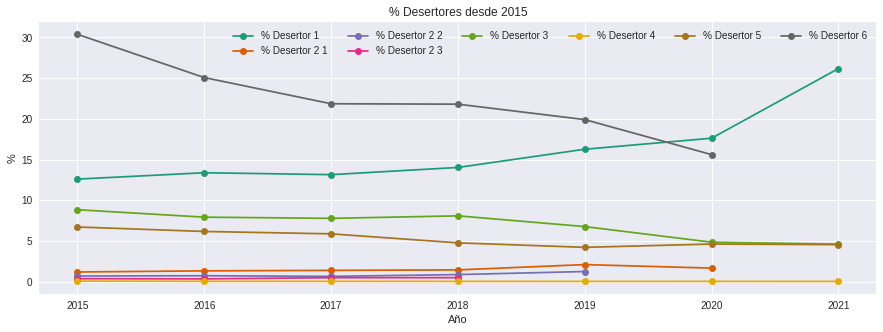

In [46]:
# ['% Desertor 1', '% Desertor 2 1', '% Desertor 2 2', '% Desertor 2 3', '% Desertor 3', '% Desertor 4', '% Desertor 5', '% Desertor 6']
plt.figure(figsize=(15, 5))
color = plt.cm.Dark2(np.linspace(0, 1, 8))
for i, c in enumerate(df_plots.columns[1:]):
    plt.plot(df_plots["cat_periodo"], df_plots[c], "-o", label=c, color=color[i])

plt.title("% Desertores desde 2015")
plt.xlabel("Año")
plt.ylabel("%")
plt.legend(ncol=6);

- 1: Sale del sistema y no vuelve a ingresar
- 2: Sale del sistema y vuelve después de 1, 2 ó 3 años a la misma carrera en la misma institución (no deserta, "congela")
- 3: Sale y vuelve a otra carrera en la misma institución (seudo deserción?)
- 4: Sale y vuelve a la misma carrera en otra institución (seudo deserción?)
- 5: Sale y vuelve a otra carrera en otra institución (seudo deserción?)
- 6: Sale del sistema, vuelve a ingresar, pero no termina ni se matricula 2022 (múltiple deserción?)